# curbage_recall Figures
## Aging shifts recall of naturalistic events from temporal to topic organization
#### Angelique I. Delarazan, Katherine March, Elena Markantonakis, June Dy, and Zach Reagh

## Set Up

### Import Packages

In [1]:
import matplotlib.pyplot as plt
import glob
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
from scipy import stats
import itertools
import statsmodels.api as sm 
from statsmodels.formula.api import ols 
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import plot_partregress_grid
import pingouin as pg
from pingouin import anova as pg_anova
from psifr import fr
import tensorflow as tf
import tensorflow_hub as hub
import rpy2
from scipy.spatial.distance import squareform
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import chisquare
from pingouin import mixed_anova
import statsmodels.api as sm 
from statsmodels.formula.api import ols 
from scipy.stats.stats import pearsonr
import ptitprince as pt

/Users/aidelarazan/miniconda3/envs/kramer/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/Users/aidelarazan/miniconda3/envs/kramer/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
def plot_correlation(data, x, y, color, xlabel, ylabel):
    fig, ax = plt.subplots(figsize=(2.4, 2.4), facecolor='none')

    sns.regplot(
        data=data,
        x=x,
        y=y,
        color=color,
        scatter_kws={'s': 10, 'edgecolor': 'none'},
        line_kws={'linewidth': None}, 
        truncate=True,
        ax=ax
    )

    ax.set_xlabel(xlabel, fontsize=8)
    ax.set_ylabel(ylabel, fontsize=8)
    ax.tick_params(axis='x', labelsize=6)
    ax.tick_params(axis='y', labelsize=6)

    return fig, ax

In [3]:
condition_colors = {
    'older': '#2a3f67',
    'younger': '#91323d',
    'all': '#450d64',
    'temporal_cluster_light':'#cf7a35',
    'temporal_cluster_dark': '#ca6b1e',
    'category_cluster_light':'#ffece4',
    'category_cluster_dark':'#307095',
    'semantic_cluster_light':'#f0dcf4',
    'semantic_cluster_dark':'#5d3877',
    'coherent_short': '#6b7a8d',
    'coherent_long': '#2a3f67',
    'unrelated_short': '#b27077',
    'unrelated_long': '#91323d'
}

### Load Data

#### Read in Recall

In [5]:
recall = pd.read_csv('~/Box Sync/aidelarazan_box/Projects/curbage_behavioral/github/data/curbage_recall_sub-all_group-all_task-main_desc-recall.csv')
recall.sort_values(by=['subject', 'recall_order'], inplace=True)
recall = recall[['subject', 'group', 'version', 'event', 'recall_description', 'recall_order', 'scene', 'scene_location', 'theme', 'word_count']]
recall.sort_values(by=['subject', 'recall_order'], inplace=True)
recall['recall_order'] = recall.groupby('subject').cumcount() + 1
recall = recall.reset_index(drop=True)
recall = recall.rename(columns={'recall_description': 'description', 'recall_order': 'position', 'event':'item'})
recall = recall.assign(trial_type='recall')
recall = recall.assign(list=1)
recall['item'] = recall['item'].astype(str)
recall['position'] = recall['position'].astype(int) 
recall = recall[['subject', 'group', 'version', 'list', 'trial_type', 'item', 'scene', 'scene_location', 'theme', 'word_count', 'position', 'description']]
subjects = recall['subject'].unique().tolist()
recall.head()

,subject,group,version,list,trial_type,item,scene,scene_location,theme,word_count,position,description
0,101,older,exp2,1,recall,A1,A,Walking on the Street,Caterer,30,1,"Okay, this was an episode of Curb Your Enthusi..."
1,101,older,exp2,1,recall,A3,A,Walking on the Street,Caterer,10,2,that he was carrying that was actually tuna fi...
2,101,older,exp2,1,recall,A2,A,Walking on the Street,Chevy,22,3,and Jeff his friends said that he was going to...
3,101,older,exp2,1,recall,A3,A,Walking on the Street,Caterer,26,4,"and then larry, as they were they're walking d..."
4,101,older,exp2,1,recall,other,C,Jeff's Office,Other,42,5,and they go upstairs or they go to the office ...


#### Read in Encoding

In [7]:
encoding = pd.read_csv('~/Box Sync/aidelarazan_box/Projects/curbage_behavioral/github/data/curbage_recall_desc-annotations.csv')
encoding['event_num'] = encoding['event_num'].astype(int)
encoding.sort_values(by=['event_num'], inplace=True)
encoding = encoding.rename(columns={'event_description': 'description', 'event_num': 'position', 'event':'item'})
encoding = encoding.assign(trial_type='study')
encoding = encoding.assign(list=1)
encoding['item'] = encoding['item'].astype(str)
encoding.head()

,item,position,scene,scene_location,theme,description,trial_type,list
0,A1,1,A,Walking on the Street,Caterer,Larry and Jeff are walking down the street. La...,study,1
1,A2,2,A,Walking on the Street,Chevy,Jeff tells Larry that he is getting a 57 Chevy...,study,1
2,A3,3,A,Walking on the Street,Caterer,A homeless man holding a cup interrupts Larry ...,study,1
3,B1,4,B,The David's Back Patio,Other,Larry walks through his kitchen and into the p...,study,1
4,B2,5,B,The David's Back Patio,Dinner_Party,Julie gets up to leave and mentions the dinner...,study,1


In [8]:
encoding_tmp = []

for subject in subjects:
    current_df = encoding.copy()
    current_df['subject'] = subject
    encoding_tmp.append(current_df)

encoded_story = pd.concat(encoding_tmp)
encoded_story = encoded_story.dropna()
encoded_story['group'] = encoded_story['subject'].apply(lambda x: 'younger' if 200 < x < 400 else 'older')
encoded_story['version'] = encoded_story['subject'].apply(lambda x: 'exp1' if x > 300 else 'exp2')
encoded_story['word_count'] = encoded_story['description'].str.split().str.len()
encoded_story = encoded_story[['subject', 'group', 'version', 'list', 'trial_type', 'item', 'scene', 'scene_location', 'theme', 'position', 'description', 'word_count']]
encoded_story.head()

,subject,group,version,list,trial_type,item,scene,scene_location,theme,position,description,word_count
0,101,older,exp2,1,study,A1,A,Walking on the Street,Caterer,1,Larry and Jeff are walking down the street. La...,14
1,101,older,exp2,1,study,A2,A,Walking on the Street,Chevy,2,Jeff tells Larry that he is getting a 57 Chevy...,14
2,101,older,exp2,1,study,A3,A,Walking on the Street,Caterer,3,A homeless man holding a cup interrupts Larry ...,60
3,101,older,exp2,1,study,B1,B,The David's Back Patio,Other,4,Larry walks through his kitchen and into the p...,65
4,101,older,exp2,1,study,B2,B,The David's Back Patio,Dinner_Party,5,Julie gets up to leave and mentions the dinner...,13


In [9]:
story = pd.concat([encoded_story, recall])
story.head()

,subject,group,version,list,trial_type,item,scene,scene_location,theme,position,description,word_count
0,101,older,exp2,1,study,A1,A,Walking on the Street,Caterer,1,Larry and Jeff are walking down the street. La...,14
1,101,older,exp2,1,study,A2,A,Walking on the Street,Chevy,2,Jeff tells Larry that he is getting a 57 Chevy...,14
2,101,older,exp2,1,study,A3,A,Walking on the Street,Caterer,3,A homeless man holding a cup interrupts Larry ...,60
3,101,older,exp2,1,study,B1,B,The David's Back Patio,Other,4,Larry walks through his kitchen and into the p...,65
4,101,older,exp2,1,study,B2,B,The David's Back Patio,Dinner_Party,5,Julie gets up to leave and mentions the dinner...,13


In [10]:
story_df = fr.merge_free_recall(story, study_keys=['group', 'version', 'theme', 'scene_location'])
story_df.head()

,subject,list,item,input,output,study,recall,repeat,intrusion,group,version,theme,scene_location,prior_list,prior_input
0,101,1,A1,1.0,1.0,True,True,0,False,older,exp2,Caterer,Walking on the Street,NaN,NaN
1,101,1,A2,2.0,3.0,True,True,0,False,older,exp2,Chevy,Walking on the Street,NaN,NaN
2,101,1,A3,3.0,2.0,True,True,0,False,older,exp2,Caterer,Walking on the Street,NaN,NaN
3,101,1,A3,3.0,4.0,False,True,1,False,older,exp2,Caterer,Walking on the Street,NaN,NaN
4,101,1,B1,4.0,9.0,True,True,0,False,older,exp2,Other,The David's Back Patio,NaN,NaN


#### Recall Performance (Word Count)

In [11]:
story[story['trial_type']=='recall'].groupby(['subject', 'group', 'version'])['word_count'].sum().reset_index()

,subject,group,version,word_count
0,101,older,exp2,2562
1,102,older,exp2,452
2,107,older,exp2,1226
3,108,older,exp2,1157
4,113,older,exp2,2025
...,...,...,...,...
79,417,older,exp1,953
80,418,older,exp1,2752
81,419,older,exp1,1699
82,420,older,exp1,246


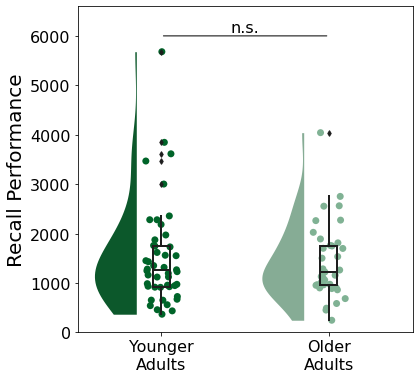

In [163]:
fig, ax = plt.subplots(figsize=(6, 6), facecolor='none')

xtick_order = ['younger', 'older']
xtick_labels = {
    'younger': 'Younger\nAdults',
    'older': 'Older\nAdults',
}
xtick_colors = {
    'younger': '#006429',
    'older': '#80B294',    
}

# Swarmplot
pt.half_violinplot(
    data=story[story['trial_type'] == 'recall'].groupby(['subject', 'group', 'version'])['word_count'].sum().reset_index(),
    x='group',
    y='word_count',
    hue='group',
    hue_order=xtick_order,
    palette=xtick_colors, 
    bw=0.5, 
    cut=0, 
    scale="area", 
    width=0.5, 
    inner=None,
    order=xtick_order, 
    split=True,
    linewidth=0,
)

# Pointplot
sns.boxplot(
    data=story[story['trial_type'] == 'recall'].groupby(['subject', 'group', 'version'])['word_count'].sum().reset_index(),
    x='group',
    y='word_count',
    palette=xtick_colors, 
    width=0.1, 
    order=xtick_order,
    fliersize=4,
    zorder=10,
    showcaps=False, 
    linewidth=2,
    boxprops={'facecolor': 'none', "zorder": 10, 'linewidth': 2},
    showfliers=True, 
    whiskerprops={'linewidth': 2, "zorder": 10}
)

# Pointplot
sns.stripplot(
    data=story[story['trial_type'] == 'recall'].groupby(['subject', 'group', 'version'])['word_count'].sum().reset_index(),
    x='group',
    y='word_count',
    palette=xtick_colors, 
    edgecolor="black",
    size=7, 
    jitter=1, 
    zorder=0,
    order=xtick_order
)

# Axis labels and ticks
ax.set_ylabel('Recall Performance', fontsize=20)
ax.set_xlabel('')
ax.set_xticks(range(len(xtick_order)))
ax.set_xticklabels([xtick_labels[label] for label in xtick_order])

# Add significance line
xy = (0, 6000)
xytext = (1, 6000)
center = ((xy[0] + xytext[0]) / 2, (xy[1] + xytext[1]) / 2)

ax.annotate('', xy=xy, xytext=xytext, arrowprops=dict(arrowstyle='-', color='black'))
ax.text(center[0], center[1] + 15, 'n.s.', ha='center', va='bottom', fontsize=16)

# Adjust plot limits and aesthetics
ax.set_ylim(0, 6600)
ax.tick_params(labelsize=16)
ax.legend_.remove()

# plt.savefig('/Users/aidelarazan/Box Sync/aidelarazan_box/Conferences/DACC2025/figures/curbage_recall_performance.png', dpi=300, bbox_inches='tight')
plt.show()

### Serial Position Curve

In [17]:
spc_grouped = fr.spc(story_df).reset_index()
spc_grouped['group'] = spc_grouped['subject'].apply(lambda x: 'younger' if 200 < x < 400 else 'older')
spc_grouped

,subject,input,recall,group
0,101,1.0,True,older
1,101,2.0,True,older
2,101,3.0,True,older
3,101,4.0,True,older
4,101,5.0,True,older
...,...,...,...,...
3103,421,33.0,False,older
3104,421,34.0,False,older
3105,421,35.0,False,older
3106,421,36.0,True,older


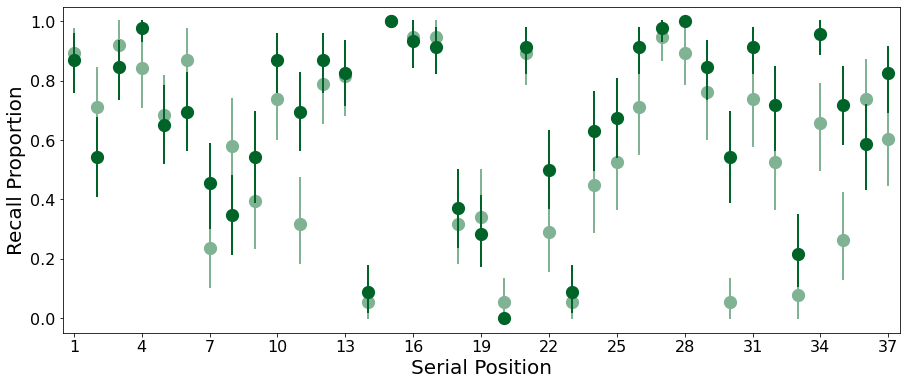

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6), facecolor='none')

xtick_order = ['younger', 'older']
xtick_labels = {
    'younger':'Younger',
    'older':'Older',
}
xtick_colors = {
    'younger': '#006429',
    'older': '#80B294',    
}

ax=sns.pointplot(
    data=spc_grouped,
    x='input',
    y='recall',
    linewidth=3,
    hue='group',
    linestyles="",
    palette=xtick_colors,
    errwidth=2,
    markers='o',
    scale=1.5, 
    ax=ax
)

ax.set_ylabel('Recall Proportion', fontsize=20)
ax.set_xlabel('Serial Position', fontsize=20)
ax.tick_params(labelsize=16)
ax.legend_.remove()
# ax.set_xticklabels(range(0, 38), fontsize=8)

ax.set_xticks(np.arange(0, 37, 3)) 
ax.set_xticklabels(np.arange(1, 38, 3))


# plt.savefig('/Users/aidelarazan/Box Sync/aidelarazan_box/Conferences/DACC2025/figures/curbage_recall_spc.png', dpi=300, bbox_inches='tight')


#### Lag-CRP

In [18]:
lagcrp = fr.lag_crp(story_df).reset_index()
lagcrp['lag'] = lagcrp['lag'].astype(int)
lagcrp['group'] = lagcrp['subject'].apply(lambda x: 'younger' if 200 < x < 400 else 'older')
lagcrp['version'] = lagcrp['subject'].apply(lambda x: 'exp1' if x > 300 else 'exp2')
lagcrp['direction'] = lagcrp['lag'].apply(lambda x: 'forward' if x > 0 else 'backward')
lagcrp.head()

,subject,lag,prob,actual,possible,group,version,direction
0,101,-36,NaN,0,0,older,exp2,backward
1,101,-35,NaN,0,0,older,exp2,backward
2,101,-34,NaN,0,0,older,exp2,backward
3,101,-33,NaN,0,0,older,exp2,backward
4,101,-32,NaN,0,0,older,exp2,backward


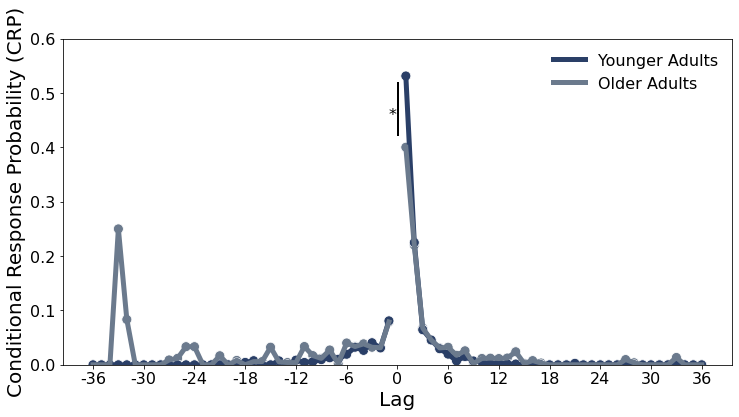

In [ ]:
lagcrp = fr.lag_crp(story_df).reset_index()
lagcrp['lag'] = lagcrp['lag'].astype(int)
lagcrp['group'] = lagcrp['subject'].apply(lambda x: 'younger' if 200 < x < 400 else 'older')
lagcrp.head()

fig, ax = plt.subplots(figsize=(12, 6), facecolor='none')

xtick_order = ['younger', 'older']

xtick_labels = {
    'younger': 'Younger Adults',
    'older': 'Older Adults',
}
xtick_colors = {
    'younger': '#2a3f67', 
    'older': '#6b7a8d',    
}

# Plotting the lineplot for segments excluding -1 and 1
sns.lineplot(
    data=lagcrp[(lagcrp['lag'] > -1) & (lagcrp['lag'] < 1)],
    x='lag',
    y='prob',
    linewidth=5,
    hue='group',
    palette=xtick_colors,
    hue_order=xtick_order,
    ci=None,
    # legend=False,
    ax=ax
)

# Plotting separate line segments for data before -1 and after 1
sns.lineplot(
    data=lagcrp[lagcrp['lag'] <= -1],
    x='lag',
    y='prob',
    linewidth=5,
    hue='group',
    ci=None,
    palette=xtick_colors,
    hue_order=xtick_order,
    # legend=False,
    ax=ax
)

sns.lineplot(
    data=lagcrp[lagcrp['lag'] >= 1],
    x='lag',
    y='prob',
    linewidth=5,
    hue='group',
    ci=None,
    palette=xtick_colors,
    hue_order=xtick_order,
    # legend=False,
    ax=ax
)

# Scatterplot for mean values excluding lag = 0
mean_values = lagcrp.groupby(['lag', 'group'])['prob'].mean().reset_index()

sns.scatterplot(
    data=mean_values[mean_values['lag'] != 0],
    x='lag',
    y='prob',
    hue='group',
    hue_order=xtick_order,
    palette=xtick_colors,
    s=100,
    ax=ax
)

# Add a vertical significance line at lag = +1
ax.vlines(x=0.1, ymin=0.42, ymax=0.52, color='black', linestyle='-', linewidth=2)

# Optional text for the significance marker
ax.text(-0.15, 0.46, '*', ha='right', va='center', fontsize=16)

# Setting x-axis ticks to integers from -36 to 36 with a step of 6
ax.set_xticks(range(-36, 37, 6))
ax.set_xticklabels(range(-36, 37, 6), fontsize=16)

# Setting axis labels and other plot parameters
ax.set_ylabel('Conditional Response Probability (CRP)', fontsize=20)
ax.set_xlabel('Lag', fontsize=20)
ax.tick_params(labelsize=16)
ax.set_ylim(0, 0.6)
ax.legend_.remove()

ax.legend(
    labels=[xtick_labels[label] for label in xtick_order],  # Use custom labels
    title="",
    title_fontsize=16,
    fontsize=16,
    loc="upper right",
    frameon=False  # Removes the border around the legend
)

# plt.savefig('/Users/aidelarazan/Box Sync/aidelarazan_box/Conferences/DACC2025/figures/curbage_recall_lagcrp.png', dpi=300, bbox_inches='tight')

plt.show()


### Temporal Clustering

In [19]:
temporal_cluster = fr.lag_rank(story_df).reset_index()
temporal_cluster['group'] = temporal_cluster['subject'].apply(lambda x: 'younger' if 200 < x < 400 else 'older')
temporal_cluster['version'] = temporal_cluster['subject'].apply(lambda x: 'exp1' if x > 300 else 'exp2')
temporal_cluster.head()

,subject,rank,group,version
0,101,0.794559,older,exp2
1,102,0.652631,older,exp2
2,107,0.914802,older,exp2
3,108,0.870524,older,exp2
4,113,0.912836,older,exp2


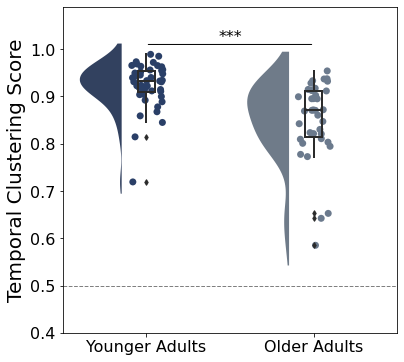

In [165]:
fig, ax = plt.subplots(figsize=(6, 6), facecolor='none')

xtick_order = ['younger', 'older'] 
xtick_labels = {
    'younger': 'Younger Adults',
    'older': 'Older Adults',
}
xtick_colors = {
    'younger': '#2a3f67',
    'older': '#6b7a8d',
}

# Swarmplot
pt.half_violinplot(
    data=temporal_cluster,
    x='group',
    y='rank',
    hue='group',
    hue_order=xtick_order,
    palette=xtick_colors, 
    bw=0.5, 
    cut=1,
    scale="area", 
    width=0.5, 
    inner=None,
    order=xtick_order, 
    split=True,
    linewidth=0,
)

# Pointplot
sns.boxplot(
    data=temporal_cluster,
    x='group',
    y='rank',
    palette=xtick_colors, 
    width=0.1, 
    order=xtick_order,
    fliersize=4,
    zorder=10,
    showcaps=False, 
    linewidth=2,
    boxprops={'facecolor': 'none', "zorder": 10, 'linewidth': 2},
    showfliers=True, 
    whiskerprops={'linewidth': 2, "zorder": 10}
)

# Pointplot
sns.stripplot(
    data=temporal_cluster,
    x='group',
    y='rank',
    palette=xtick_colors, 
    edgecolor="black",
    size=7, 
    jitter=1, 
    zorder=0,
    order=xtick_order
)

# Axis labels and ticks
ax.set_ylabel('Temporal Clustering Score', fontsize=20)
ax.set_xlabel('')
ax.set_xticks(range(len(xtick_order)))
ax.set_xticklabels([xtick_labels[label] for label in xtick_order])

# Add significance line
xy = (0, 1.01)
xytext = (1, 1.01)
center = ((xy[0] + xytext[0]) / 2, (xy[1] + xytext[1]) / 2)

ax.annotate('', xy=xy, xytext=xytext, arrowprops=dict(arrowstyle='-', color='black'))
ax.text(center[0], center[1] + .00001, '***', ha='center', va='bottom', fontsize=16)

# Adjust plot limits and aesthetics
ax.set_ylim(0.4, 1.09)
ax.tick_params(labelsize=16)
ax.legend_.remove()

ax.axhline(0.5, linestyle='--', color='gray', linewidth=1)

# plt.savefig('/Users/aidelarazan/Box Sync/aidelarazan_box/Conferences/DACC2025/figures/curbage_recall_temporal_clustering.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
temporal_cluster.sort_values(by='rank')

,subject,rank,group,version
66,404,0.585144,older,exp1
63,401,0.642225,older,exp1
1,102,0.652631,older,exp2
47,305,0.719186,younger,exp1
68,406,0.772747,older,exp1
...,...,...,...,...
55,313,0.968778,younger,exp1
24,220,0.972045,younger,exp2
28,233,0.973363,younger,exp2
34,256,0.985087,younger,exp2


### Topic Clustering Scores

In [21]:
topic_cluster = fr.category_clustering(story_df, category_key='theme').reset_index()
topic_cluster['group'] = topic_cluster['subject'].apply(lambda x: 'younger' if 200 < x < 400 else 'older')
topic_cluster['version'] = topic_cluster['subject'].apply(lambda x: 'exp1' if x > 300 else 'exp2')
topic_cluster.head()

,subject,lbc,arc,group,version
0,101,5.187500,0.366906,older,exp2
1,102,2.166667,0.470588,older,exp2
2,107,1.958333,0.100977,older,exp2
3,108,5.500000,0.315068,older,exp2
4,113,2.041667,0.077449,older,exp2


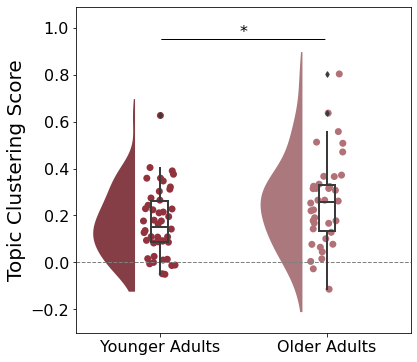

In [167]:
fig, ax = plt.subplots(figsize=(6, 6), facecolor='none')

xtick_order = ['younger', 'older'] 
xtick_labels = {
    'younger': 'Younger Adults',
    'older': 'Older Adults',
}
xtick_colors = {
    'younger': '#91323d',
    'older': '#b27077',  
}

# Swarmplot
pt.half_violinplot(
    data=topic_cluster,
    x='group',
    y='arc',
    hue='group',
    hue_order=xtick_order,
    palette=xtick_colors, 
    bw=0.5, 
    cut=1, 
    scale="area", 
    width=0.5, 
    inner=None,
    order=xtick_order, 
    split=True,
    linewidth=0,
)

# Pointplot
sns.boxplot(
    data=topic_cluster,
    x='group',
    y='arc',
    palette=xtick_colors, 
    width=0.1, 
    order=xtick_order,
    fliersize=4,
    zorder=10,
    showcaps=False, 
    linewidth=2,
    boxprops={'facecolor': 'none', "zorder": 10, 'linewidth': 2},
    showfliers=True, 
    whiskerprops={'linewidth': 2, "zorder": 10}
)

# Pointplot
sns.stripplot(
    data=topic_cluster,
    x='group',
    y='arc',
    palette=xtick_colors, 
    edgecolor="black",
    size=7, 
    jitter=1, 
    zorder=0,
    order=xtick_order
)

# Axis labels and ticks
ax.set_ylabel('Topic Clustering Score', fontsize=20)
ax.set_xlabel('')
ax.set_xticks(range(len(xtick_order)))
ax.set_xticklabels([xtick_labels[label] for label in xtick_order])

# Add significance line
xy = (0, .95)
xytext = (1, .95)
center = ((xy[0] + xytext[0]) / 2, (xy[1] + xytext[1]) / 2)

ax.annotate('', xy=xy, xytext=xytext, arrowprops=dict(arrowstyle='-', color='black'))
ax.text(center[0], center[1] + .00001, '*', ha='center', va='bottom', fontsize=16)

# Adjust plot limits and aesthetics
ax.set_ylim(-0.3, 1.09)
ax.tick_params(labelsize=16)
ax.legend_.remove()

ax.axhline(0, linestyle='--', color='gray', linewidth=1)

# plt.savefig('/Users/aidelarazan/Box Sync/aidelarazan_box/Conferences/DACC2025/figures/curbage_recall_topic_clustering.png', dpi=300, bbox_inches='tight')
plt.show()

### Narrative Centrality

#### Causal Centrality

#### Causality Ratings (Network)

In [33]:
movie = pd.read_csv('/Users/aidelarazan/Box Sync/aidelarazan_box/Projects/curbage_behavioral/github/data/curbage_recall_desc-annotations.csv')
movie = movie[['scene', 'scene_location', 'theme',
       'event_description', 'event', 'event_num']]
movie = movie.rename(columns={'event_num':'event_number'})
movie

,scene,scene_location,theme,event_description,event,event_number
0,A,Walking on the Street,Caterer,Larry and Jeff are walking down the street. La...,A1,1
1,A,Walking on the Street,Chevy,Jeff tells Larry that he is getting a 57 Chevy...,A2,2
2,A,Walking on the Street,Caterer,A homeless man holding a cup interrupts Larry ...,A3,3
3,A,Walking on the Street,Caterer,A homeless man holding a cup interrupts Larry ...,A3,3
4,A,Walking on the Street,Caterer,A homeless man holding a cup interrupts Larry ...,A3,3
...,...,...,...,...,...,...
88,K,Walking on the Street,Caterer,Larry is walking down the street with platters...,K1,36
89,K,Walking on the Street,Caterer,Larry is walking down the street with platters...,K1,36
90,K,Walking on the Street,Caterer,Larry is walking down the street with platters...,K1,36
91,K,Walking on the Street,Caterer,Larry is walking down the street with platters...,K1,36


In [34]:
movie_descriptions = movie.drop_duplicates(subset=['event_number']).reset_index(drop=True)
movie_descriptions

,scene,scene_location,theme,event_description,event,event_number
0,A,Walking on the Street,Caterer,Larry and Jeff are walking down the street. La...,A1,1
1,A,Walking on the Street,Chevy,Jeff tells Larry that he is getting a 57 Chevy...,A2,2
2,A,Walking on the Street,Caterer,A homeless man holding a cup interrupts Larry ...,A3,3
3,B,The David's Back Patio,Other,Larry walks through his kitchen and into the p...,B1,4
4,B,The David's Back Patio,Dinner_Party,Julie gets up to leave and mentions the dinner...,B2,5
5,B,The David's Back Patio,Caterer,Cheryl mentions that their caterer cancelled. ...,B3,6
6,B,The David's Back Patio,Dinner_Party,Cheryl tells Julie she cannot wait to meet Pat...,B4,7
7,B,The David's Back Patio,Caterer,Larry picks up the phone and leaves Jeff a mes...,B5,8
8,B,The David's Back Patio,Other,Cheryl tells Larry that Julie liked the movie ...,B6,9
9,B,The David's Back Patio,Dinner_Party,Larry questions why she wants to have a dinner...,B7,10


In [35]:
base_dir = '~/Box Sync/aidelarazan_box/Projects/curbage_behavioral/data/narrative_centrality/recoded/'
base_dir = os.path.expanduser(base_dir)
files = glob.glob(os.path.join(base_dir, "*.csv"))

ratings = []

for filename in files:
    df = pd.read_csv(filename)
    df = df[['pair_number', 'event_cause_recoded', 'event_effect_recoded', 'justification']]
    # Extract subject number from filename
    subject = int(filename.split('_')[-1].split('.')[0].split('-')[-1])
    # Add subject column to DataFrame
    df['subject'] = subject
    ratings.append(df)

# Concatenate all data frames
causality_ratings = pd.concat(ratings, ignore_index=True)
causality_ratings = causality_ratings.dropna(subset=['justification'])

causality_ratings = causality_ratings[['subject', 'pair_number', 'event_cause_recoded', 'event_effect_recoded', 'justification']]
causality_ratings = causality_ratings.reset_index(drop=True)

# Combine cause and effect columns into one
causality_ratings['event_cause'] = causality_ratings['event_cause_recoded'].astype(int)
causality_ratings['event_effect'] = causality_ratings['event_effect_recoded'].astype(int)
causality_ratings['event_pairs'] = causality_ratings['event_cause'].astype(str) + "_" + causality_ratings['event_effect'].astype(str)
causality_ratings

,subject,pair_number,event_cause_recoded,event_effect_recoded,justification,event_cause,event_effect,event_pairs
0,114,1.0,1,3,homeless man assumes they have money/food beca...,1,3,1_3
1,114,2.0,4,5,"as julie leaves, she mentions the dinner party...",4,5,4_5
2,114,5.0,4,9,since julie did not seem enthusiatic about sou...,4,9,4_9
3,114,3.0,5,7,"since julie is her friend leaving, cheryl ment...",5,7,5_7
4,114,4.0,6,8,"since cheryl mentioned the caterer cancelled, ...",6,8,6_8
...,...,...,...,...,...,...,...,...
418,118,15.0,19,23,Larry knows he'll fix the car so he says so.,19,23,19_23
419,118,16.0,10,24,Making the bet prompted the reminder.,10,24,10_24
420,118,17.0,27,27,Thought she took the food so they called her.,27,27,27_27
421,118,18.0,27,28,Said he was coming for the food so he did.,27,28,27_28


In [36]:
causality_ratings['edge_width'] = causality_ratings.groupby('event_pairs')['event_pairs'].transform('count')
causality_ratings.reset_index(drop=True)
causality_ratings.head()

,subject,pair_number,event_cause_recoded,event_effect_recoded,justification,event_cause,event_effect,event_pairs,edge_width
0,114,1.0,1,3,homeless man assumes they have money/food beca...,1,3,1_3,4
1,114,2.0,4,5,"as julie leaves, she mentions the dinner party...",4,5,4_5,2
2,114,5.0,4,9,since julie did not seem enthusiatic about sou...,4,9,4_9,14
3,114,3.0,5,7,"since julie is her friend leaving, cheryl ment...",5,7,5_7,3
4,114,4.0,6,8,"since cheryl mentioned the caterer cancelled, ...",6,8,6_8,12


In [37]:
causality_ratings['event_number'] = causality_ratings['event_cause']
causality_ratings = movie_descriptions.merge(causality_ratings, how='inner', on='event_number')
causality_ratings = causality_ratings.rename(columns={'event_number':'eventA_number','scene':'eventA_scene','scene_location':'eventA_scene_location','theme':'eventA_theme','event_description':'eventA_description'})


In [39]:
causality_ratings['event_number'] = causality_ratings['event_effect']
causality_ratings = movie_descriptions.merge(causality_ratings, how='inner', on='event_number')
causality_ratings = causality_ratings.rename(columns={'event_number':'eventB_number','scene':'eventB_scene','scene_location':'eventB_scene_location','theme':'eventB_theme','event_description':'eventB_description'})
causality_ratings

,eventB_scene,eventB_scene_location,eventB_theme,eventB_description,event_x,eventB_number,eventA_scene,eventA_scene_location,eventA_theme,eventA_description,...,eventA_number,subject,pair_number,event_cause_recoded,event_effect_recoded,justification,event_cause,event_effect,event_pairs,edge_width
0,A,Walking on the Street,Caterer,A homeless man holding a cup interrupts Larry ...,A3,3,A,Walking on the Street,Caterer,Larry and Jeff are walking down the street. La...,...,1,114,1.0,1,3,homeless man assumes they have money/food beca...,1,3,1_3,4
1,A,Walking on the Street,Caterer,A homeless man holding a cup interrupts Larry ...,A3,3,A,Walking on the Street,Caterer,Larry and Jeff are walking down the street. La...,...,1,102,1.0,1,3,Larry walking past the homeless man prompted t...,1,3,1_3,4
2,A,Walking on the Street,Caterer,A homeless man holding a cup interrupts Larry ...,A3,3,A,Walking on the Street,Caterer,Larry and Jeff are walking down the street. La...,...,1,103,1.0,1,3,Larry walking past the homeless man prompted t...,1,3,1_3,4
3,A,Walking on the Street,Caterer,A homeless man holding a cup interrupts Larry ...,A3,3,A,Walking on the Street,Caterer,Larry and Jeff are walking down the street. La...,...,1,109,1.0,1,3,Homeless man sees Larry's bag and knows that h...,1,3,1_3,4
4,B,The David's Back Patio,Dinner_Party,Julie gets up to leave and mentions the dinner...,B2,5,B,The David's Back Patio,Other,Larry walks through his kitchen and into the p...,...,4,114,2.0,4,5,"as julie leaves, she mentions the dinner party...",4,5,4_5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,L,The Davids' Car,Dinner_Party,Cheryl and Larry are driving from dinner and L...,L1,37,F,The Davids' Bedroom,Dinner_Party,Larry talks more about the dinner party and me...,...,24,105,3.0,24,37,Cheryl lost the bet,24,37,24_37,10
419,L,The Davids' Car,Dinner_Party,Cheryl and Larry are driving from dinner and L...,L1,37,F,The Davids' Bedroom,Dinner_Party,Larry talks more about the dinner party and me...,...,24,108,18.0,24,37,cheryl lost the best because larry did not hav...,24,37,24_37,10
420,L,The Davids' Car,Dinner_Party,Cheryl and Larry are driving from dinner and L...,L1,37,F,The Davids' Bedroom,Dinner_Party,Larry talks more about the dinner party and me...,...,24,109,16.0,24,37,Reminder of the blowjob,24,37,24_37,10
421,L,The Davids' Car,Dinner_Party,Cheryl and Larry are driving from dinner and L...,L1,37,F,The Davids' Bedroom,Dinner_Party,Larry talks more about the dinner party and me...,...,24,121,14.0,24,37,"because cheryl lost the bet, she gives larry a bj",24,37,24_37,10


In [40]:
causality_ratings = causality_ratings[[
    'subject',
    'eventA_number',
    'eventB_number',
    'eventA_scene',
    'eventB_scene',
    'eventA_scene_location',
    'eventB_scene_location',
    'eventA_theme',
    'eventB_theme',
    'eventA_description',
    'eventB_description',
    'event_cause',
    'event_effect',
    'event_pairs',
    'edge_width',
    'justification'
    ]]
causality_ratings.head()

,subject,eventA_number,eventB_number,eventA_scene,eventB_scene,eventA_scene_location,eventB_scene_location,eventA_theme,eventB_theme,eventA_description,eventB_description,event_cause,event_effect,event_pairs,edge_width,justification
0,114,1,3,A,A,Walking on the Street,Walking on the Street,Caterer,Caterer,Larry and Jeff are walking down the street. La...,A homeless man holding a cup interrupts Larry ...,1,3,1_3,4,homeless man assumes they have money/food beca...
1,102,1,3,A,A,Walking on the Street,Walking on the Street,Caterer,Caterer,Larry and Jeff are walking down the street. La...,A homeless man holding a cup interrupts Larry ...,1,3,1_3,4,Larry walking past the homeless man prompted t...
2,103,1,3,A,A,Walking on the Street,Walking on the Street,Caterer,Caterer,Larry and Jeff are walking down the street. La...,A homeless man holding a cup interrupts Larry ...,1,3,1_3,4,Larry walking past the homeless man prompted t...
3,109,1,3,A,A,Walking on the Street,Walking on the Street,Caterer,Caterer,Larry and Jeff are walking down the street. La...,A homeless man holding a cup interrupts Larry ...,1,3,1_3,4,Homeless man sees Larry's bag and knows that h...
4,114,4,5,B,B,The David's Back Patio,The David's Back Patio,Other,Dinner_Party,Larry walks through his kitchen and into the p...,Julie gets up to leave and mentions the dinner...,4,5,4_5,2,"as julie leaves, she mentions the dinner party..."


In [42]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges based on event numbers and correlation
for index, row in causality_ratings.iterrows():
    eventA_number = row['eventA_number']
    eventB_number = row['eventB_number']
    correlation = row['edge_width']
    eventA_theme = row['eventA_theme']
    eventB_theme = row['eventB_theme']
    
    # Add nodes if not already present
    if not G.has_node(eventA_number):
        G.add_node(eventA_number, theme=eventA_theme)
    if not G.has_node(eventB_number):
        G.add_node(eventB_number, theme=eventB_theme)
    
    # Skip self-loops (eventA_number == eventB_number)
    if eventA_number != eventB_number:
        # Add edge between event A and event B with correlation as weight
        G.add_edge(eventA_number, eventB_number, weight=correlation)

# Calculate the degree of each node
node_degrees = dict(G.degree())

# Determine node sizes based on node degrees
node_sizes = [v * 40 for v in node_degrees.values()]

# Position nodes using spring layout
pos = nx.spring_layout(G, iterations=60, seed=155, k=1)

# Extract unique themes
unique_themes = set(nx.get_node_attributes(G, 'theme').values())

# Define colors for each theme
theme_colors = {'Caterer': '#440154', 'Chevy': '#21918c', 'Dinner_Party': '#fde725', 'Other': '#ca6b1e'}

# Assign colors to nodes based on theme
node_colors = [theme_colors[G.nodes[node]['theme']] for node in G.nodes()]

# Extract edge weights (correlation values)
edge_weights = [G.edges[edge]['weight'] for edge in G.edges()]

# Scale edge widths based on correlation
min_corr = min(edge_weights)
max_corr = max(edge_weights)
edge_widths = [1 * (weight - min_corr) / (max_corr - min_corr) for weight in edge_weights]

# Plot the narrative network with edges thickness based on correlation values
plt.figure(figsize=(7.5, 2.5), facecolor='none')
plt.title("Causal Narrative Network", fontsize=8)
nx.draw(G, pos, node_size=node_sizes, node_color=node_colors, with_labels=True, font_size=8, font_color='black', alpha=0.7, arrows=False, edge_color='gray')
nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color='gray', arrowstyle='-')
# plt.savefig('/Users/aidelarazan/Box Sync/aidelarazan_box/Projects/curbage_behavioral/figures/figures_11.23.2024/curbage_recall_fig5a.png', dpi=300, bbox_inches='tight')

plt.show()


ModuleNotFoundError: No module named 'networkx'

In [45]:
centrality_ratings = pd.read_csv('/Users/aidelarazan/Box Sync/aidelarazan_box/Projects/curbage_behavioral/github/data/curbage_recall_sub-all_group-younger_task-narrative_centrality_desc-ratings.csv')

centrality_ratings['centrality'] = pd.qcut(
    centrality_ratings['cause_count'], 
    q=[0, 0.4, 0.6, 1.0],
    labels=['Low', 'Med', 'High']
)
centrality_ratings.sort_values(by='input').reset_index(drop=True)
centrality_ratings.head()

,input,cause_count,effect_count,total_count,centrality
0,20,0,0,0,Low
1,25,1,0,1,Low
2,1,4,0,4,Low
3,14,1,5,6,Low
4,3,3,4,7,Low


In [47]:
causal_centrality = pd.merge(centrality_ratings, story_df, on='input', how='inner')
causal_centrality['recall'] = causal_centrality['recall'].astype(int)
causal_centrality_avg = causal_centrality.groupby(['subject', 'centrality'])['recall'].mean().reset_index()
causal_centrality_avg['group'] = causal_centrality_avg['subject'].apply(lambda x: 'younger' if 200 < x < 400 else 'older')
causal_centrality_avg['version'] = causal_centrality_avg['subject'].apply(lambda x: 'exp1' if x > 300 else 'exp2')
# Restrict the column to only 'Low' and 'High'
causal_centrality_avg = causal_centrality_avg[causal_centrality_avg['centrality']!='Med']
causal_centrality_avg['centrality'] = causal_centrality_avg['centrality'].astype(str)
causal_centrality_avg.reset_index(drop=True, inplace=True)
causal_centrality_avg.tail()


,subject,centrality,recall,group,version
163,419,High,0.888889,older,exp1
164,420,Low,0.125000,older,exp1
165,420,High,0.411765,older,exp1
166,421,Low,0.500000,older,exp1
167,421,High,0.800000,older,exp1


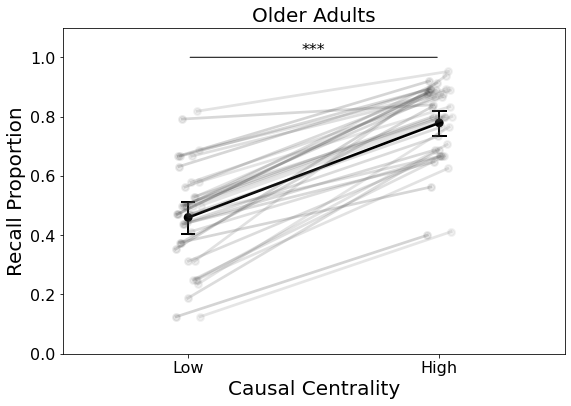

In [172]:
xtick_colors = {
    'younger': '#32405e',
    'older': '#70798e'
}

centrality_scp_plot = causal_centrality_avg[causal_centrality_avg['centrality'] != 'Med'].copy()

centrality_scp_plot['centrality'] = pd.Categorical(centrality_scp_plot['centrality'], categories=['Low', 'High'])

# Create the plot
fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')

# Plotting the first pointplot (semi-transparent)
sns.pointplot(
    data=centrality_scp_plot[centrality_scp_plot['group'] == 'older'],
    x='centrality', 
    y='recall', 
    hue='subject',  # This will color-code the subjects
    dodge=.1,  
    color='grey',  # Set all points to grey
    markers='o',  # Set marker to be circles
    scale=1,  # Increase marker size if needed
    ax=ax
)

for line in ax.lines:
    line.set_alpha(0.2) 

for collection in ax.collections:
    collection.set_alpha(0.1) 

sns.pointplot(
    data=centrality_scp_plot[centrality_scp_plot['group'] == 'older'],
    x='centrality', 
    y='recall', 
    hue=None,  
    capsize=0.05,  
    color='black', 
    errwidth=2,  
    markers='o', 
    scale=1, 
    ax=ax,
    zorder=1000 
)

# Customize the plot
ax.set_ylabel('Recall Proportion', fontsize=20)
ax.set_xlabel('Causal Centrality', fontsize=20)
ax.title.set_text('Older Adults')
ax.title.set_fontsize(20)
ax.tick_params(labelsize=16)
xy = (0, 1) 
xytext = (1, 1)
center = ((xy[0] + xytext[0]) / 2, (xy[1] + xytext[1]) / 2)

ax.annotate('', xy=xy, xytext=xytext, arrowprops=dict(arrowstyle='-', color='black'))
ax.text(center[0], center[1] + .05, '***', ha='center', va='top', fontsize=16)
ax.set_ylim(0, 1.1)  
ax.tick_params(labelsize=16)
ax.legend_.remove()

# plt.savefig('/Users/aidelarazan/Box Sync/aidelarazan_box/Conferences/DACC2025/figures/curbage_recall_causal_centrality_OA.png', dpi=300, bbox_inches='tight')
plt.show()

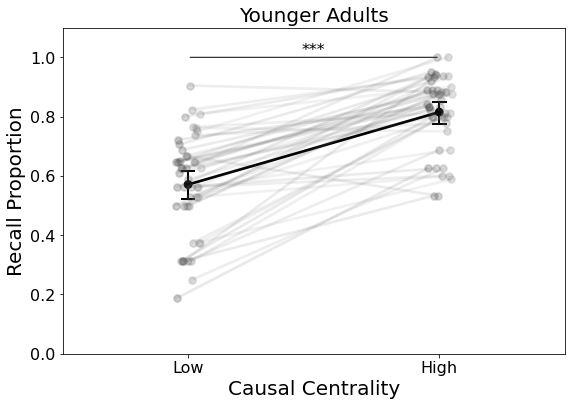

In [174]:
xtick_colors = {
    'younger': '#32405e',
    'older': '#70798e'
}

centrality_scp_plot = causal_centrality_avg[causal_centrality_avg['centrality'] != 'Med'].copy()

centrality_scp_plot['centrality'] = pd.Categorical(centrality_scp_plot['centrality'], categories=['Low', 'High'])

# Create the plot
fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')


sns.pointplot(
    data=centrality_scp_plot[centrality_scp_plot['group'] == 'younger'],
    x='centrality', 
    y='recall', 
    hue='subject', 
    dodge=.1,  
    color='grey',  
    markers='o', 
    scale=1, 
    ax=ax
)

for line in ax.lines:
    line.set_alpha(0.1) 


for collection in ax.collections:
    collection.set_alpha(0.2) 


sns.pointplot(
    data=centrality_scp_plot[centrality_scp_plot['group'] == 'younger'],
    x='centrality', 
    y='recall', 
    hue=None,  
    capsize=0.05,  
    color='black', 
    errwidth=2,
    markers='o', 
    scale=1,  
    ax=ax,
    zorder=1000  
)

# Customize the plot
ax.set_ylabel('Recall Proportion', fontsize=20)
ax.set_xlabel('Causal Centrality', fontsize=20)
ax.title.set_text('Younger Adults')
ax.title.set_fontsize(20)
ax.tick_params(labelsize=16)
xy = (0, 1) 
xytext = (1, 1)
center = ((xy[0] + xytext[0]) / 2, (xy[1] + xytext[1]) / 2)

ax.annotate('', xy=xy, xytext=xytext, arrowprops=dict(arrowstyle='-', color='black'))
ax.text(center[0], center[1] + .05, '***', ha='center', va='top', fontsize=16)
ax.set_ylim(0, 1.1)  
ax.tick_params(labelsize=16)
ax.legend_.remove()

# plt.savefig('/Users/aidelarazan/Box Sync/aidelarazan_box/Conferences/DACC2025/figures/curbage_recall_causal_centrality_YA.png', dpi=300, bbox_inches='tight')
plt.show()

#### Semantic Centrality

##### Universal Sentence Encoder Modules

In [52]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [53]:
encoding = pd.read_csv('~/Box Sync/aidelarazan_box/Projects/curbage_behavioral/github/data/curbage_recall_desc-annotations.csv')
encoding['event_num'] = encoding['event_num'].astype(int)
encoding.sort_values(by=['event_num'], inplace=True)
encoding = encoding.rename(columns={'event_description': 'description', 'event_num': 'position', 'event':'item'})
encoding = encoding.assign(trial_type='study')
encoding = encoding.assign(list=1)
encoding['item'] = encoding['item'].astype(str)
encoding.head()

,item,position,scene,scene_location,theme,description,trial_type,list
0,A1,1,A,Walking on the Street,Caterer,Larry and Jeff are walking down the street. La...,study,1
1,A2,2,A,Walking on the Street,Chevy,Jeff tells Larry that he is getting a 57 Chevy...,study,1
2,A3,3,A,Walking on the Street,Caterer,A homeless man holding a cup interrupts Larry ...,study,1
3,B1,4,B,The David's Back Patio,Other,Larry walks through his kitchen and into the p...,study,1
4,B2,5,B,The David's Back Patio,Dinner_Party,Julie gets up to leave and mentions the dinner...,study,1


In [54]:
threshold = 0.59
semantic_centrality = []

# Iterate through each pair of event descriptions
for i in range(len(encoding)):
    for j in range(i + 1, len(encoding)):
        position_i = encoding.loc[i, 'position']
        position_j = encoding.loc[j, 'position']

        scene_i = encoding.loc[i, 'scene']
        scene_j = encoding.loc[j, 'scene']

        scene_location_i = encoding.loc[i, 'scene_location']
        scene_location_j = encoding.loc[j, 'scene_location']

        theme_i = encoding.loc[i, 'theme']
        theme_j = encoding.loc[j, 'theme']

        description_i = encoding.loc[i, 'description']
        description_j = encoding.loc[j, 'description']
        
        # Compute embeddings for both event descriptions
        event_description_embedding_i = np.array(embed([description_i])).tolist()
        event_description_embedding_j = np.array(embed([description_j])).tolist()
        
        # Compute correlation between embeddings
        correlation = np.inner(event_description_embedding_i, event_description_embedding_j)[0][0]
        
        # Store the pair and their correlation
        curr_dict = {
            'eventA_position': position_i,
            'eventB_position': position_j,
            'eventA_scene': scene_i,
            'eventB_scene': scene_j,
            'eventA_scene_location': scene_location_i,
            'eventB_scene_location': scene_location_j,
            'eventA_theme': theme_i,
            'eventB_theme': theme_j,
            'eventA_description': description_i,
            'eventB_description': description_j,
            'correlation': correlation
        }
        semantic_centrality.append(curr_dict)

# Create DataFrame from list of dictionaries
semantic_centrality = pd.DataFrame(semantic_centrality)
semantic_centrality = semantic_centrality[semantic_centrality['correlation'] > threshold].reset_index(drop=True)
semantic_centrality.head()


,eventA_position,eventB_position,eventA_scene,eventB_scene,eventA_scene_location,eventB_scene_location,eventA_theme,eventB_theme,eventA_description,eventB_description,correlation
0,1,11,A,C,Walking on the Street,Jeff's Office,Caterer,Caterer,Larry and Jeff are walking down the street. La...,Jeff and Larry are in Jeff's office and Jeff t...,0.623495
1,1,16,A,E,Walking on the Street,Dinner Party,Caterer,Dinner_Party,Larry and Jeff are walking down the street. La...,"At the dinner party, Larry talks to a couple w...",0.591348
2,1,30,A,I,Walking on the Street,Jeff's Kitchen,Caterer,Chevy,Larry and Jeff are walking down the street. La...,Jeff brings up a message that Larry left him a...,0.680375
3,2,12,A,C,Walking on the Street,Jeff's Office,Chevy,Chevy,Jeff tells Larry that he is getting a 57 Chevy...,Jeff moves to the couch and tells Larry that h...,0.659799
4,2,29,A,I,Walking on the Street,Jeff's Kitchen,Chevy,Caterer,Jeff tells Larry that he is getting a 57 Chevy...,Jeff is eating the leftover chicken when Larry...,0.596201


In [55]:
threshold = 0.59

event_similarity_thresholded = semantic_centrality[semantic_centrality['correlation']>threshold].reset_index(drop=True)
event_similarity_thresholded

,eventA_position,eventB_position,eventA_scene,eventB_scene,eventA_scene_location,eventB_scene_location,eventA_theme,eventB_theme,eventA_description,eventB_description,correlation
0,1,11,A,C,Walking on the Street,Jeff's Office,Caterer,Caterer,Larry and Jeff are walking down the street. La...,Jeff and Larry are in Jeff's office and Jeff t...,0.623495
1,1,16,A,E,Walking on the Street,Dinner Party,Caterer,Dinner_Party,Larry and Jeff are walking down the street. La...,"At the dinner party, Larry talks to a couple w...",0.591348
2,1,30,A,I,Walking on the Street,Jeff's Kitchen,Caterer,Chevy,Larry and Jeff are walking down the street. La...,Jeff brings up a message that Larry left him a...,0.680375
3,2,12,A,C,Walking on the Street,Jeff's Office,Chevy,Chevy,Jeff tells Larry that he is getting a 57 Chevy...,Jeff moves to the couch and tells Larry that h...,0.659799
4,2,29,A,I,Walking on the Street,Jeff's Kitchen,Chevy,Caterer,Jeff tells Larry that he is getting a 57 Chevy...,Jeff is eating the leftover chicken when Larry...,0.596201
...,...,...,...,...,...,...,...,...,...,...,...
66,27,28,G,H,The Davids' Kitchen,Caterer's House,Caterer,Caterer,Larry wants an apple turnover and walks over t...,Larry is at the caterer's house and asks for t...,0.668046
67,29,30,I,I,Jeff's Kitchen,Jeff's Kitchen,Caterer,Chevy,Jeff is eating the leftover chicken when Larry...,Jeff brings up a message that Larry left him a...,0.631102
68,30,31,I,J,Jeff's Kitchen,AAMCO Station,Chevy,Chevy,Jeff brings up a message that Larry left him a...,Larry and Jeff are at the AAMCO station. Mike ...,0.601443
69,30,33,I,J,Jeff's Kitchen,AAMCO Station,Chevy,Chevy,Jeff brings up a message that Larry left him a...,And Jeff tells Larry to apologize if he has to.,0.611680


In [57]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges based on event numbers and correlation
for index, row in event_similarity_thresholded.iterrows():
    eventA_number = row['eventA_position']
    eventB_number = row['eventB_position']
    correlation = row['correlation']
    eventA_theme = row['eventA_theme']
    eventB_theme = row['eventB_theme']
    
    # Add nodes if not already present
    if not G.has_node(eventA_number):
        G.add_node(eventA_number, theme=eventA_theme)
    if not G.has_node(eventB_number):
        G.add_node(eventB_number, theme=eventB_theme)
    
    # Skip self-loops (eventA_number == eventB_number)
    if eventA_number != eventB_number:
        # Add edge between event A and event B with correlation as weight
        G.add_edge(eventA_number, eventB_number, weight=correlation)

# Calculate the degree of each node
node_degrees = dict(G.degree())

# Determine node sizes based on node degrees
node_sizes = [v * 40 for v in node_degrees.values()]

# Position nodes using spring layout
pos = nx.spring_layout(G, iterations=60, seed=155, k=1)

# Extract unique themes
unique_themes = set(nx.get_node_attributes(G, 'theme').values())

# Define colors for each theme
theme_colors = {'Caterer': '#440154', 'Chevy': '#21918c', 'Dinner_Party': '#fde725', 'Other': '#ca6b1e'}

# Assign colors to nodes based on theme
node_colors = [theme_colors[G.nodes[node]['theme']] for node in G.nodes()]

# Extract edge weights (correlation values)
edge_weights = [G.edges[edge]['weight'] for edge in G.edges()]

# Scale edge widths based on correlation
min_corr = min(edge_weights)
max_corr = max(edge_weights)
edge_widths = [1 * (weight - min_corr) / (max_corr - min_corr) for weight in edge_weights]

# Plot the narrative network with edges thickness based on correlation values
plt.figure(figsize=(7.5, 2.5), facecolor='none')
plt.title("Semantic Narrative Network", fontsize=8)
nx.draw(G, pos, node_size=node_sizes, node_color=node_colors, with_labels=True, font_size=8, font_color='black', alpha=0.7, arrows=False, edge_color='gray')
nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color='gray', arrowstyle='-')
# plt.savefig('/Users/aidelarazan/Box Sync/aidelarazan_box/Projects/curbage_behavioral/figures/figures_11.23.2024/curbage_recall_fig4a.png', dpi=300, bbox_inches='tight')

plt.show()


ModuleNotFoundError: No module named 'networkx'

In [65]:
# Sort the semantic_centrality DataFrame by 'correlation'
sorted_semantic_centrality = semantic_centrality.sort_values('correlation').reset_index(drop=True)

# # Concatenate the two position columns into a single Series
event_similarity_values = pd.concat([sorted_semantic_centrality['eventA_position'], 
                                      sorted_semantic_centrality['eventB_position']])

# # Use value_counts on the Series
event_similarity_counts = event_similarity_values.value_counts().reset_index()

# # Rename the columns
event_similarity_counts.columns = ['input', 'count']

# Display the first few rows of the resulting Data Frame
event_similarity_counts.tail(60) 


,input,count
0,30,12
1,24,11
2,26,9
3,12,9
4,23,9
5,22,8
6,34,8
7,16,7
8,17,7
9,11,7


In [66]:
semantic_ratings = event_similarity_counts.copy()

# Create a new column 'cause_count_category' based on quantiles
semantic_ratings['centrality'] = pd.qcut(
    semantic_ratings['count'], 
    q=[0, 0.4, 0.6, 1.0],  # Quantile thresholds: 0-40%, 40-60%, 60-100%
    labels=['Low', 'Med', 'High']  # Labels for the categories
)
semantic_ratings.sort_values(by='input').reset_index(drop=True)
semantic_ratings.head(60)

,input,count,centrality
0,30,12,High
1,24,11,High
2,26,9,High
3,12,9,High
4,23,9,High
5,22,8,High
6,34,8,High
7,16,7,High
8,17,7,High
9,11,7,High


In [68]:
semantic_centrality = pd.merge(semantic_ratings, story_df, on='input', how='inner')
semantic_centrality['recall'] = semantic_centrality['recall'].astype(int)
semantic_centrality_avg = semantic_centrality.groupby(['subject', 'centrality'])['recall'].mean().reset_index()
semantic_centrality_avg['group'] = semantic_centrality_avg['subject'].apply(lambda x: 'younger' if 200 < x < 400 else 'older')
semantic_centrality_avg['version'] = semantic_centrality_avg['subject'].apply(lambda x: 'exp1' if x > 300 else 'exp2')
# Restrict the column to only 'Low' and 'High'
semantic_centrality_avg = semantic_centrality_avg[semantic_centrality_avg['centrality']!='Med']
semantic_centrality_avg['centrality'] = semantic_centrality_avg['centrality'].astype(str)
semantic_centrality_avg.reset_index(drop=True, inplace=True)
semantic_centrality_avg.tail()


,subject,centrality,recall,group,version
163,419,High,0.846154,older,exp1
164,420,Low,0.142857,older,exp1
165,420,High,0.384615,older,exp1
166,421,Low,0.533333,older,exp1
167,421,High,0.454545,older,exp1


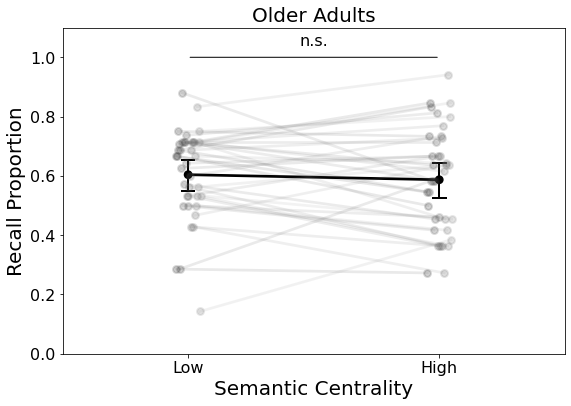

In [185]:
xtick_colors = {
    'younger': '#863e46',
    'older': '#b68b90'
}

centrality_scp_plot = semantic_centrality_avg[semantic_centrality_avg['centrality'] != 'Med'].copy()

centrality_scp_plot['centrality'] = pd.Categorical(centrality_scp_plot['centrality'], categories=['Low', 'High'])

# Create the plot
fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')

sns.pointplot(
    data=centrality_scp_plot[centrality_scp_plot['group'] == 'older'],
    x='centrality', 
    y='recall', 
    hue='subject', 
    dodge=.1,  
    color='grey', 
    markers='o',  
    scale=1, 
    ax=ax
)

for line in ax.lines:
    line.set_alpha(0.1)  

for collection in ax.collections:
    collection.set_alpha(0.2) 


sns.pointplot(
    data=centrality_scp_plot[centrality_scp_plot['group'] == 'older'],
    x='centrality', 
    y='recall', 
    hue=None,  
    capsize=0.05,  
    color='black', 
    errwidth=2, 
    markers='o', 
    scale=1,  
    ax=ax,
    zorder=1000 
)

# Customize the plot
ax.set_ylabel('Recall Proportion', fontsize=20)
ax.set_xlabel('Semantic Centrality', fontsize=20)
ax.title.set_text('Older Adults')
ax.title.set_fontsize(20)
ax.tick_params(labelsize=16)
xy = (0, 1) 
xytext = (1, 1)
center = ((xy[0] + xytext[0]) / 2, (xy[1] + xytext[1]) / 2)

ax.annotate('', xy=xy, xytext=xytext, arrowprops=dict(arrowstyle='-', color='black'))
ax.text(center[0], center[1] + .08, 'n.s.', ha='center', va='top', fontsize=16)
ax.set_ylim(0, 1.1)  
ax.tick_params(labelsize=16)
ax.legend_.remove()

# plt.savefig('/Users/aidelarazan/Box Sync/aidelarazan_box/Conferences/DACC2025/figures/curbage_recall_semantic_centrality_OA.png', dpi=300, bbox_inches='tight')
plt.show()

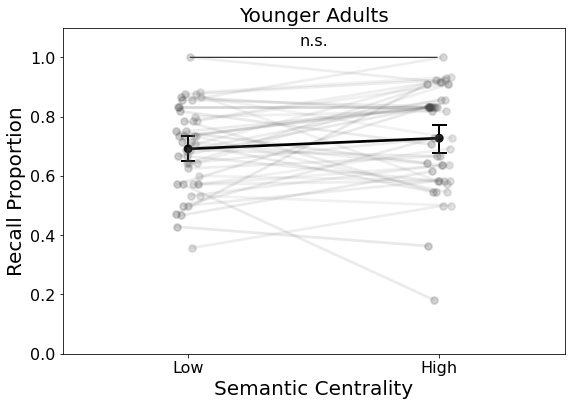

In [ ]:
xtick_colors = {
    'younger': '#863e46',
    'older': '#b68b90'
}

centrality_scp_plot = semantic_centrality_avg[semantic_centrality_avg['centrality'] != 'Med'].copy()

centrality_scp_plot['centrality'] = pd.Categorical(centrality_scp_plot['centrality'], categories=['Low', 'High'])

# Create the plot
fig, ax = plt.subplots(figsize=(9, 6), facecolor='none')

sns.pointplot(
    data=centrality_scp_plot[centrality_scp_plot['group'] == 'younger'],
    x='centrality', 
    y='recall', 
    hue='subject',
    dodge=.1,  
    color='grey', 
    markers='o', 
    scale=1,
    ax=ax
)

for line in ax.lines:
    line.set_alpha(0.1)

for collection in ax.collections:
    collection.set_alpha(0.2)

sns.pointplot(
    data=centrality_scp_plot[centrality_scp_plot['group'] == 'younger'],
    x='centrality', 
    y='recall', 
    hue=None, 
    capsize=0.05, 
    color='black',  
    errwidth=2, 
    markers='o', 
    scale=1,  
    ax=ax,
    zorder=1000
)

# Customize the plot
ax.set_ylabel('Recall Proportion', fontsize=20)
ax.set_xlabel('Semantic Centrality', fontsize=20)
ax.title.set_text('Younger Adults')
ax.title.set_fontsize(20)
ax.tick_params(labelsize=16)
xy = (0, 1) 
xytext = (1, 1)
center = ((xy[0] + xytext[0]) / 2, (xy[1] + xytext[1]) / 2)

ax.annotate('', xy=xy, xytext=xytext, arrowprops=dict(arrowstyle='-', color='black'))
ax.text(center[0], center[1] + .08, 'n.s.', ha='center', va='top', fontsize=16)
ax.set_ylim(0, 1.1)  
ax.tick_params(labelsize=16)
ax.legend_.remove()

# plt.savefig('/Users/aidelarazan/Box Sync/aidelarazan_box/Conferences/DACC2025/figures/curbage_recall_semantic_centrality_YA.png', dpi=300, bbox_inches='tight')
plt.show()

### Correlations: Clustering Scores and Recall Performance

In [72]:
story[story['trial_type']=='recall'].groupby(['subject'])['word_count'].sum().reset_index()

,subject,word_count
0,101,2562
1,102,452
2,107,1226
3,108,1157
4,113,2025
...,...,...
79,417,953
80,418,2752
81,419,1699
82,420,246


In [73]:
temporal_rank = fr.lag_rank(story_df).reset_index()
temporal_rank['rank_type'] = 'temporal'
temporal_rank['chance_rank'] = 0.5
temporal_rank.head()

,subject,rank,rank_type,chance_rank
0,101,0.794559,temporal,0.5
1,102,0.652631,temporal,0.5
2,107,0.914802,temporal,0.5
3,108,0.870524,temporal,0.5
4,113,0.912836,temporal,0.5


In [74]:
topic_rank = fr.category_clustering(story_df, category_key='theme').reset_index()
topic_rank = topic_rank.rename(columns={'arc': 'rank'})
topic_rank['rank_type'] = 'topic'
topic_rank['chance_rank'] = 0.0
topic_rank = topic_rank[['subject', 'rank', 'rank_type', 'chance_rank']]
topic_rank.head()

,subject,rank,rank_type,chance_rank
0,101,0.366906,topic,0.0
1,102,0.470588,topic,0.0
2,107,0.100977,topic,0.0
3,108,0.315068,topic,0.0
4,113,0.077449,topic,0.0


In [76]:
rank = pd.concat([temporal_rank, topic_rank]) 
rank.tail()

,subject,rank,rank_type,chance_rank
79,417,0.307292,topic,0.0
80,418,0.333333,topic,0.0
81,419,0.004184,topic,0.0
82,420,0.636364,topic,0.0
83,421,-0.114286,topic,0.0


In [77]:
cluster_recall = pd.merge(story[story['trial_type']=='recall'].groupby(['subject', 'group', 'version'])['word_count'].sum().reset_index(), rank, how='inner')
cluster_recall.head()

,subject,group,version,word_count,rank,rank_type,chance_rank
0,101,older,exp2,2562,0.794559,temporal,0.5
1,101,older,exp2,2562,0.366906,topic,0.0
2,102,older,exp2,452,0.652631,temporal,0.5
3,102,older,exp2,452,0.470588,topic,0.0
4,107,older,exp2,1226,0.914802,temporal,0.5


Temporal Clustering and Recall Performance

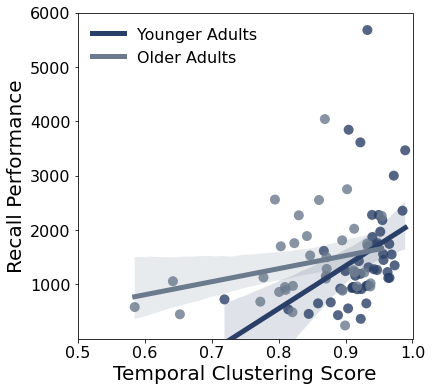

In [189]:
fig, ax = plt.subplots(figsize=(6, 6), facecolor='none')

xtick_order = ['younger', 'older']
xtick_labels = {
    'younger':'Younger Adults',
    'older':'Older Adults',
}
xtick_colors = {
    'younger': '#2a3f67', 
    'older': '#6b7a8d',   
}

# Regression plot
ax=sns.regplot(
    data=cluster_recall[(cluster_recall['group']=='younger')&(cluster_recall['rank_type']=='temporal')],
    x='rank',
    y='word_count',
    color=xtick_colors['younger'],
    scatter_kws={'s': 100, 'edgecolor': 'none'}, 
    line_kws={'linewidth': 5},  
    truncate=True,
    ax=ax
)

# Regression plot
ax=sns.regplot(
    data=cluster_recall[(cluster_recall['group']=='older')&(cluster_recall['rank_type']=='temporal')],
    x='rank',
    y='word_count',
    color=xtick_colors['older'],
    scatter_kws={'s': 100, 'edgecolor': 'none'},
    line_kws={'linewidth': 5}, 
    truncate=True,
    ax=ax
)

ax.set_xticks(np.arange(0.5, 1.01, 0.1)) 
ax.set_xticklabels([f'{x:.1f}' for x in np.arange(0.5, 1.1, 0.1)])
ax.set_xlabel('Temporal Clustering Score', fontsize=20)
ax.set_ylabel('Recall Performance', fontsize=20)
ax.set_ylim(1, 6000)  
ax.tick_params(labelsize=16)
# ax.legend_.remove()

ax.legend(
    labels=[xtick_labels[label] for label in xtick_order], 
    title="",
    title_fontsize=16,
    fontsize=16,
    loc="upper left",
    frameon=False 
)

# plt.savefig('/Users/aidelarazan/Box Sync/aidelarazan_box/Conferences/DACC2025/figures/curbage_recall_correlation_recall_performance_temporal_clustering_score.png', dpi=300, bbox_inches='tight')


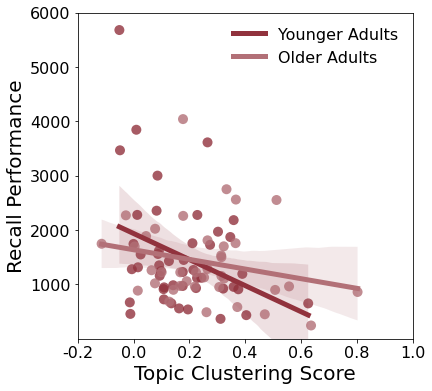

In [190]:
fig, ax = plt.subplots(figsize=(6, 6), facecolor='none')

xtick_order = ['younger', 'older']
xtick_labels = {
    'younger':'Younger Adults',
    'older':'Older Adults',
}
xtick_colors = {
    'younger': '#91323d', 
    'older': '#b27077',  
}

# Regression plot
ax=sns.regplot(
    data=cluster_recall[(cluster_recall['group']=='younger')&(cluster_recall['rank_type']=='topic')],
    x='rank',
    y='word_count',
    color=xtick_colors['younger'],
    scatter_kws={'s': 100, 'edgecolor': 'none'},  
    line_kws={'linewidth': 5}, 
    truncate=True,
    ax=ax
)

# Regression plot
ax=sns.regplot(
    data=cluster_recall[(cluster_recall['group']=='older')&(cluster_recall['rank_type']=='topic')],
    x='rank',
    y='word_count',
    color=xtick_colors['older'],
    scatter_kws={'s': 100, 'edgecolor': 'none'},  
    line_kws={'linewidth': 5}, 
    truncate=True,
    ax=ax
)


ax.set_xticks(np.arange(-0.2, 1.1, 0.2))  
ax.set_xticklabels([f'{x:.1f}' for x in np.arange(-0.2, 1.1, 0.2)]) 

# Axes labels and ticks
ax.set_xlabel('Topic Clustering Score', fontsize=20)
ax.set_ylabel('Recall Performance', fontsize=20)
ax.set_ylim(1, 6000)  
# Customize tick label font size
ax.tick_params(labelsize=16)
# ax.legend_.remove()

ax.legend(
    labels=[xtick_labels[label] for label in xtick_order], 
    title="",
    title_fontsize=16,
    fontsize=16,
    loc="upper right",
    frameon=False 
)

# Save (optional)
# plt.savefig('/Users/aidelarazan/Box Sync/aidelarazan_box/Conferences/DACC2025/figures/curbage_recall_correlation_recall_performance_topic_clustering_score.png', dpi=300, bbox_inches='tight')
